## 4th Cycle of Data Science Life Cycle
Here I create so functions to validate models and to fund parameters

### Imports

In [111]:
import numpy as np 
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
    
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Business Understanding
* Exogenous factors:
    * Generation data (biomass, fossil fuels, wind, solar)
    * Load data (forecast or actual)
    * Weather data (temp, wind_speed, rain, humidity, preassure, clouds, snow)
    * Other prices data (fuel price, other market price...) 
***    
Some references:
<br>
Article about feature engineering techniques for time series data <a href='https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/' target="_blank">here</a>
<br>
Article about multivariate time series forecasting using random forests <a href="https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1" target="_blank">here</a>. 
<br>
Kaggle notebook about electricity price forecasting with DNNs <a href="https://www.kaggle.com/dimitriosroussis/electricity-price-forecasting-with-dnns-eda" target="_blank">here</a>.
<br>
Kaggle notebook about time Series - Exploratory Data Analysis & Forecast <a href="https://www.kaggle.com/rgrajan/time-series-exploratory-data-analysis-forecast" target="_blank">here</a>.
<br>
Article about 'Statistical Modeling of Time Series Data Part 2: Exploratory Data Analysis' <a href="https://towardsai.net/p/data-visualization/statistical-modeling-of-time-series-data-part-2-exploratory-data-analysis" target="_blank">here</a>.
<br>
Article about 'How-To Guide on Exploratory Data Analysis for Time Series Data' <a href="https://medium.com/analytics-vidhya/how-to-guide-on-exploratory-data-analysis-for-time-series-data-34250ff1d04f" target="_blank">here</a>

### Data Collection

In [112]:
#Upload main dataset for hourly market prices from June 2020 to June 2021
data = pd.read_csv('Data/price_data.csv')

In [113]:
#Upload main dataset for weather forecast from June 2020 to June 2021
weather_data = pd.read_csv('Data/weather_data.csv')

In [116]:
# Create list with all sites dataframes
site_dataframes = []
#Upload each site's dataset for weather forecast from June 2020 to June 2021
site_names = weather_data.site_name.unique()
for i in site_names:
    name= i + '_data'
    name = pd.read_csv('Data/' + i + '.csv')
    site_dataframes.append(name)

In [117]:
# Upload 1 year lag dataset for weather forecast from June 2019 to June 2020
one_year_lag = pd.read_csv('Data/1_year_lag.csv')
one_year_lag = one_year_lag.rename(columns={'value': '1_year_lag'})

### Data Preparation

In [118]:
# Make sure that the days of the week of the lag and the real value are the same, 
# so shift from Sunday to Tuesday for first row
one_year_lag['1_year_lag'] = one_year_lag['1_year_lag'].shift(2).fillna({0: one_year_lag['1_year_lag'][6],
                                                                       1: one_year_lag['1_year_lag'][7]})

In [119]:
# Drop everything except the lag column
one_year_lag = one_year_lag.drop(columns=['date','start_time_uk'])

In [120]:
# Since 2020 was a leap-year, remove last column to match dataframes
one_year_lag = one_year_lag.drop(index=[360])

In [121]:
# Make a column with the index so that the two dataframes to be merged have something in common
one_year_lag['index'] = one_year_lag.index

In [122]:
# Convert dates and times to datetime in main dataframe
data['date'] = pd.to_datetime(data.date, format="%Y-%m-%d")
data['start_time_uk'] = pd.to_datetime(data.start_time_uk, 
                                       format='%H:%M:%S').dt.time

In [123]:
# Make a column with the index so that the two dataframes to be merged have something in common
data['index'] = data.index

In [124]:
# Merging the main data and the one year lag dataframe
data = data.merge(one_year_lag)

In [125]:
# Drop the index column that was created to match dataframes
data = data.drop(columns=['index'])

In [126]:
# Convert to datetime all sites dataframes
for df in site_dataframes:
    df['date'] = pd.to_datetime(df.date, format="%Y-%m-%d")
    df['start_time_uk'] = pd.to_datetime(df.start_time_uk, 
                                           format='%H:%M:%S').dt.time
    df.sort_values(by='date')

In [127]:
# Choose the only site that has data for all days
rheidol_data = site_dataframes[0]

In [128]:
# Merge the market prices data with the rheidol_data dataframe since they have same time and dates
data= data.merge(rheidol_data).drop(labels='site_name', axis=1, inplace=False)

In [129]:
# Sort by date the new dataframe
data.sort_values(by=['date'], ignore_index=True, 
                 inplace=True)

In [130]:
# Make 'date' column the index of the dataframe, and convert it to datetime
data.index = data['date'].rename('index')
data.index = pd.to_datetime(data.index)

In [131]:
#Checking for missing dates, if any found, return to 'Data Collection' to add it
pd.date_range(start = '2020-06-30', end = '2021-06-24' ).difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [132]:
#Remove outliers
outliers = data.loc[data.value > 110]['value'].values
data.value.replace(outliers, [100, 100], inplace=True)

In [133]:
# Create functions to add new columns with day of week ,year and month and weekday/weekend.
def add_day_week(dataframe):
    dataframe['weekday'] = dataframe['date'].apply(lambda x: x.weekday())
    
def add_month(dataframe):
    dataframe['month'] = dataframe['date'].apply(lambda x: x.month)
    
def add_year(dataframe):
    dataframe['year'] = dataframe['date'].apply(lambda x: x.year)
    
def add_day_week_name(dataframe):
    dataframe['weekday_name'] = dataframe['date'].apply(lambda x: x.strftime('%A'))

def add_month_name(dataframe):
    dataframe['month_name'] = dataframe['date'].apply(lambda x: x.strftime('%B'))
    
def weekday_weekend(dataframe):
    dataframe['weekday_or_weekend'] = dataframe['date'].apply(lambda x: 1 if x.strftime('%A') in ('Saturday','Sunday') else 0)
    
def add_day_of_month(dataframe):
    dataframe['day_of_month'] = dataframe['date'].apply(lambda x: x.day)

In [134]:
# Add all the new day-related columns
add_day_week(data) #Day of the week (number)
add_month(data) #Month (number)
add_year(data) #Year 
add_day_week_name(data) #Day of the week (name)
add_month_name(data) #Month (name)
weekday_weekend(data) #Binary for weekday or weekend
add_day_of_month(data) #Day of month (number) (Could be deleted later if model is not as good as before)

In [135]:
# Drop date column now that we have all the information in columns
data.drop(labels='date', axis=1, inplace=True)

In [136]:
data.info()
print("Dataframe shape: ", data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2020-06-30 to 2021-06-24
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   value               360 non-null    float64
 1   start_time_uk       360 non-null    object 
 2   1_year_lag          360 non-null    float64
 3   temperature         360 non-null    float64
 4   snow                360 non-null    float64
 5   ground_pressure     360 non-null    float64
 6   humidity            360 non-null    float64
 7   wind_speed          360 non-null    float64
 8   rain                360 non-null    float64
 9   pressure            360 non-null    float64
 10  wind_deg            360 non-null    float64
 11  clouds              360 non-null    float64
 12  weekday             360 non-null    int64  
 13  month               360 non-null    int64  
 14  year                360 non-null    int64  
 15  weekday_name        360 non-null    ob

In [137]:
# Print NaNs and duplicates in a dataframe
def NaN_duplicates(dataframe):
    print('There are {} missing values or NaNs in data.'
          .format(dataframe.isnull().values.sum()))

    duplicates_num = dataframe.duplicated(keep='first').sum()
    print('There are {} duplicate rows in data based on all columns.'
          .format(duplicates_num))

In [138]:
NaN_duplicates(data)

There are 0 missing values or NaNs in data.
There are 0 duplicate rows in data based on all columns.


In [139]:
# Build i day lag feature (revise after EDA)
def add_lag_feature(lag_num, column_to_lag, dataframe):
    """
    Adds one column to the data frame with some column's lagged values.
    Parameters:
    - lag_num: this is the number of lags we want, for example we can lag
        a column one day, two, three...
    - column_to_lag: this is the dataframe column we want to lag
    - dataframe: this is the dataframe to which we want to apply the lag function.
    """
    dataframe[str(lag_num) + '_day_lag'] = dataframe[column_to_lag].shift(lag_num).fillna(method='bfill')

In [140]:
# Add lag features
add_lag_feature(1,'value', data)
add_lag_feature(7,'value', data)

In [141]:
# Functions to add standard moving average columns
def add_standard_moving_average(window, column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's standard moving average.
    Parameters:
    - window: this is the number of rows we average over.
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe[str(window) + '_std_moving_average'] = dataframe[column_to_average].rolling(window, min_periods=1).mean()
    
# Add expanding moving average 
def add_expanding_moving_average(column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's expanding average.
    Parameters:
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe['ex_moving_average'] = dataframe[column_to_average].expanding().mean()

In [142]:
# Add moving averages
add_standard_moving_average(2,'1_day_lag',data)
add_standard_moving_average(5,'1_day_lag',data)
add_standard_moving_average(15,'1_day_lag',data)
add_expanding_moving_average('value',data)

### Exploratory Data Analysis
Description

In [143]:
data.columns.unique()

Index(['value', 'start_time_uk', '1_year_lag', 'temperature', 'snow',
       'ground_pressure', 'humidity', 'wind_speed', 'rain', 'pressure',
       'wind_deg', 'clouds', 'weekday', 'month', 'year', 'weekday_name',
       'month_name', 'weekday_or_weekend', 'day_of_month', '1_day_lag',
       '7_day_lag', '2_std_moving_average', '5_std_moving_average',
       '15_std_moving_average', 'ex_moving_average'],
      dtype='object')

<AxesSubplot:xlabel='Date', ylabel='Price(unit)'>

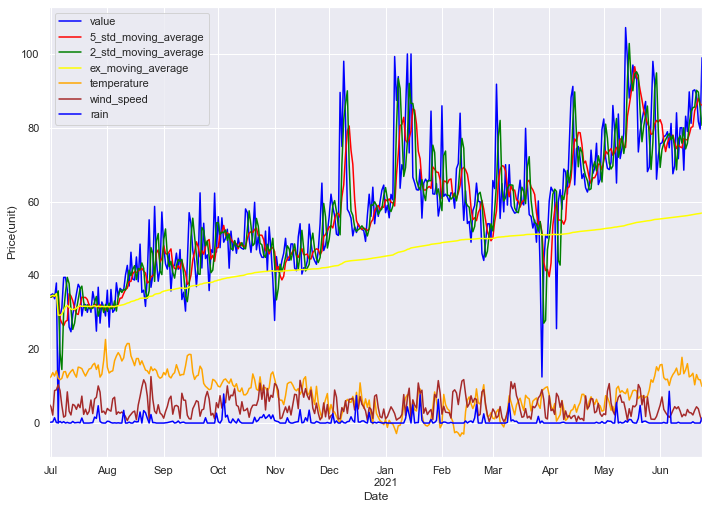

In [144]:
# Basic plot of time series and moving average.
data[['value','5_std_moving_average', '2_std_moving_average','ex_moving_average', 'temperature', 'wind_speed', 'rain']].plot(
    ylabel='Price(unit)', xlabel='Date', color=['blue', 'red','green', 'yellow', 'orange', 'brown'])

/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/monseguedesayala/opt/an

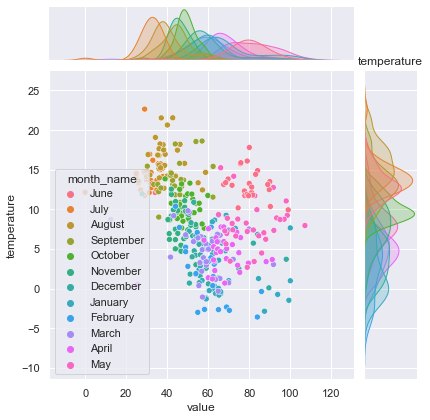

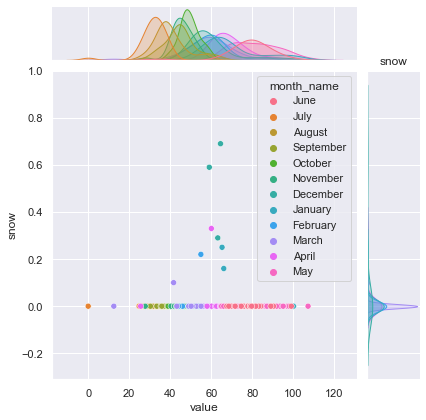

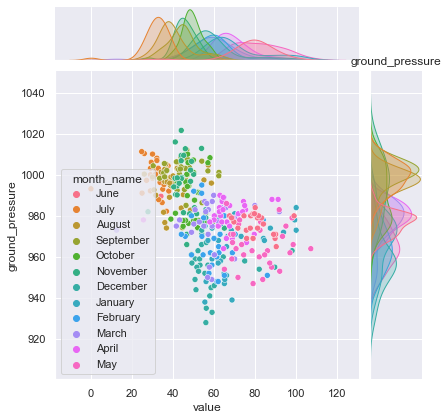

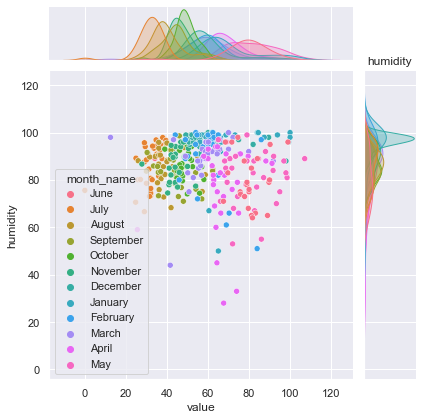

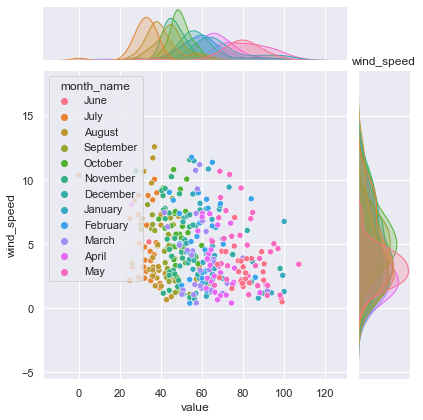

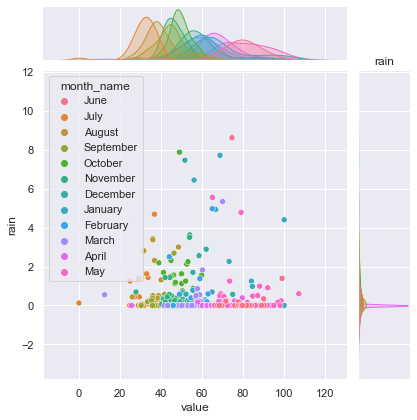

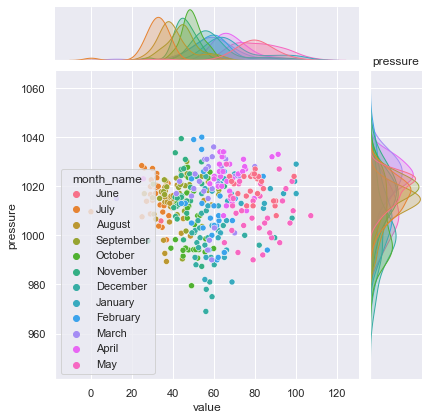

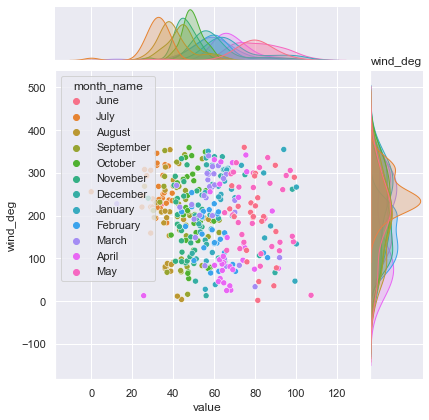

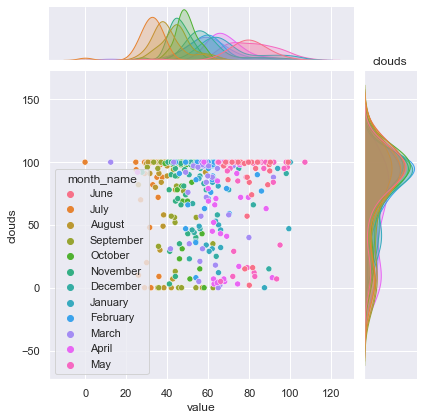

In [145]:
param_list = ['temperature', 'snow', 'ground_pressure',
       'humidity', 'wind_speed', 'rain', 'pressure', 'wind_deg',
       'clouds']
for parameter in param_list:
    sns.jointplot(data=data[['value', parameter, 'month_name']], x="value", 
                  y=parameter, hue="month_name")
    plt.title(parameter)

In [146]:
# Find correlation between features and price
correlations = data.corr(method='pearson')
print(correlations['value'].sort_values(ascending=False).to_string())

value                    1.000000
2_std_moving_average     0.834755
5_std_moving_average     0.833197
1_day_lag                0.818854
15_std_moving_average    0.816107
ex_moving_average        0.791189
7_day_lag                0.727389
year                     0.681902
snow                     0.030246
pressure                 0.025801
rain                    -0.016263
clouds                  -0.025098
humidity                -0.033694
day_of_month            -0.044872
weekday                 -0.060632
weekday_or_weekend      -0.099556
wind_deg                -0.124263
wind_speed              -0.281044
month                   -0.398657
temperature             -0.427618
1_year_lag              -0.492210
ground_pressure         -0.515157


From this we conclude that it may be good to remove: preassure, rain, snow, clouds and humidity

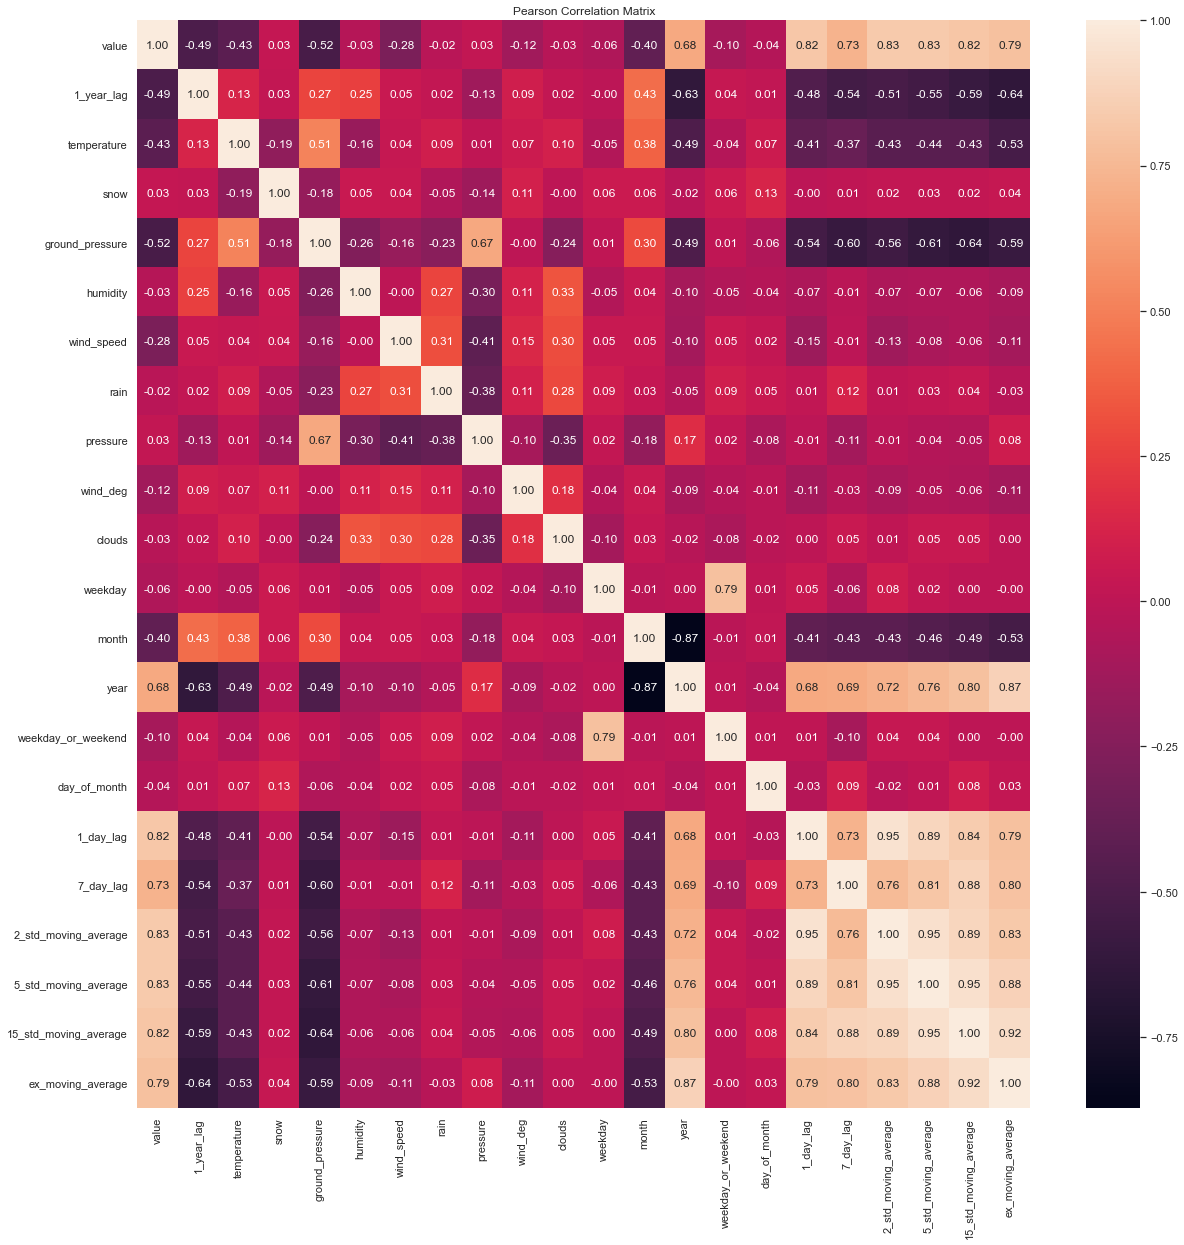

In [147]:
# Plot Pearson correlation matrix
correlations = data.corr(method='pearson')
fig = plt.figure(figsize=(20, 20))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [148]:
# Print features that are highly correlated to each other
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

value                  1_day_lag                0.818854
                       2_std_moving_average     0.834755
                       5_std_moving_average     0.833197
                       15_std_moving_average    0.816107
                       ex_moving_average        0.791189
weekday                weekday_or_weekend       0.790510
year                   5_std_moving_average     0.757505
                       15_std_moving_average    0.795203
                       ex_moving_average        0.870808
weekday_or_weekend     weekday                  0.790510
1_day_lag              value                    0.818854
                       2_std_moving_average     0.953799
                       5_std_moving_average     0.892109
                       15_std_moving_average    0.843535
                       ex_moving_average        0.792583
7_day_lag              2_std_moving_average     0.762872
                       5_std_moving_average     0.810522
                       15_std_m

In [149]:
# Stationarity check with ADF test
dftest = adfuller(data['value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.791087
p-value                          0.384896
#Lags Used                       6.000000
Number of Observations Used    353.000000
Critical Value (1%)             -3.449011
Critical Value (5%)             -2.869763
Critical Value (10%)            -2.571151
dtype: float64


In [150]:
# Apply difference transform to make data stationary
data['diff_value'] = data['value'] - data['1_day_lag']

In [151]:
# Stationarity check with ADF test
dftest = adfuller(data['diff_value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.246588e+01
p-value                        3.326611e-23
#Lags Used                     5.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64


## Modelling

#### Split dates into training and test data

In [152]:
# Function to split into training and test set the number of dates
def divide_time_df(dataframe, proportion):
    num_dates = dataframe.shape[0]
    head = round(num_dates * proportion, 0)
    tail = num_dates - head 
    print('Total days are {}'.format(data.shape[0]))
    print('Head is {}'.format(head))
    print('Tail is {}'.format(tail))
    return head,tail

In [153]:
# Divide the dates into first 80% and last 20%
head, tail = divide_time_df(data, 0.8)
data_train = data.head(int(head))
data_test = data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

Total days are 360
Head is 288.0
Tail is 72.0


### ML model

#### Convert data into training and test arrays (revise year)

In [154]:
# Train data removing the string columns and the value and diff_value
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name',
                           'weekday_name', 'year'], axis=1).values
y_train = data_train.value.values

# Test data removing the string columns and the value and diff_value
X_test = data_test.drop(['value', 'diff_value', 'start_time_uk','month_name','weekday_name','year'], axis=1).values
y_test = data_test.value.values

In [155]:
train_df = data_train.drop(['value','diff_value','start_time_uk','month_name',
                           'weekday_name', 'year'], axis=1)

#### Grid search for best parameters

In [48]:
X = data.drop(['value','diff_value','start_time_uk','month_name','weekday_name','year'], axis=1).values
y = data.value.values

def expanding_window(n, test_size, X, y, n_estimators, min_samples_split, 
                               min_samples_leaf, max_depth, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        X_train = X[:initial_train]
        X_test = X[initial_train:initial_train + test_size]
        y_train = y[:initial_train]
        y_test = y[initial_train:initial_train + test_size]
        
        forest = RandomForestRegressor(n_estimators=n_estimators, min_samples_split= min_samples_split, 
                               min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=0)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)
        
        score.append(metrics.r2_score(y_test,y_hat))
        
        if plot == True:
            plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            plt.legend()
            plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            plt.show()
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score))

In [328]:
print("Size of training set: {} size of test set: {}".format(
          X_train.shape[0], X_test.shape[0]))

RF_best_score = 0
for n_estimators in [10, 20, 50,100]: 
    for max_depth in [5,7,9,10,15,50]:
        for min_samples_split in [2,3,4]:
            for min_samples_leaf in [1,2,3,4]:
                # for each combination of parameters, train a model
                # evaluate the forest on the test set
                score = expanding_window(3, 20, X_train, y_train, n_estimators, 
                                         min_samples_split, min_samples_leaf, max_depth, False)
                # if we got a better score, store the score and parameters 
                if score > RF_best_score:
                    RF_best_score = score
                    RF_best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        
print("Best score: {:.2f}".format(RF_best_score)) 
print("Best parameters: {}".format(RF_best_parameters))

Size of training set: 288 size of test set: 72
Best score: 0.00
Best parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3}


#### Making and fitting model with chosen parameters

In [156]:
# Train data removing the string columns and the value and diff_value
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name',
                           'weekday_name', 'year'], axis=1).values
y_train = data_train.value.values
# Test data removing the string columns and the value and diff_value
X_test = data_test.drop(['value', 'diff_value', 'start_time_uk','month_name','weekday_name','year'], axis=1).values
y_test = data_test.value.values

# Model
forest = RandomForestRegressor(n_estimators=10, min_samples_split= 2, 
                               min_samples_leaf=3, max_depth=7, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

#### Model Evaluation

In [157]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.874
Accuracy on test set: -1.336


In [158]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [159]:
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

R2 is -1.3362089655665783
The mean absolute error is 12.472036617549115
The root mean squared error is 240.66000733003173
The mean absolute percentage error is 14.81029571496567


In [48]:
expanding_window(3, 20, X, y, n_estimators, min_samples_split, min_samples_leaf, max_depth, False)

NameError: name 'n_estimators' is not defined

Feature 1_year_lag , Score: 0.01580
Feature temperature , Score: 0.03552
Feature snow , Score: 0.00000
Feature ground_pressure , Score: 0.00564
Feature humidity , Score: 0.01168
Feature wind_speed , Score: 0.04329
Feature rain , Score: 0.00270
Feature pressure , Score: 0.00938
Feature wind_deg , Score: 0.01699
Feature clouds , Score: 0.00743
Feature weekday , Score: 0.02124
Feature month , Score: 0.00164
Feature weekday_or_weekend , Score: 0.00312
Feature day_of_month , Score: 0.01450
Feature 1_day_lag , Score: 0.07738
Feature 7_day_lag , Score: 0.03501
Feature 2_std_moving_average , Score: 0.27539
Feature 5_std_moving_average , Score: 0.19153
Feature 15_std_moving_average , Score: 0.04440
Feature ex_moving_average , Score: 0.18734


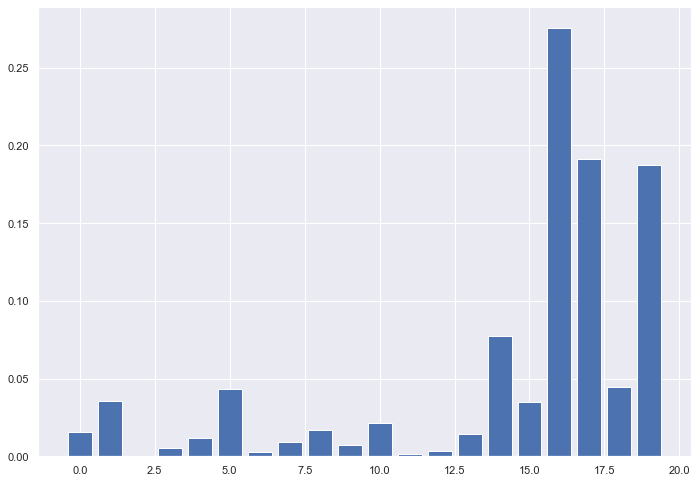

In [53]:
# Feature selection
importance = forest.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature ' + train_df.columns[i] + ' , Score: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

##### Plotting predicted and real values

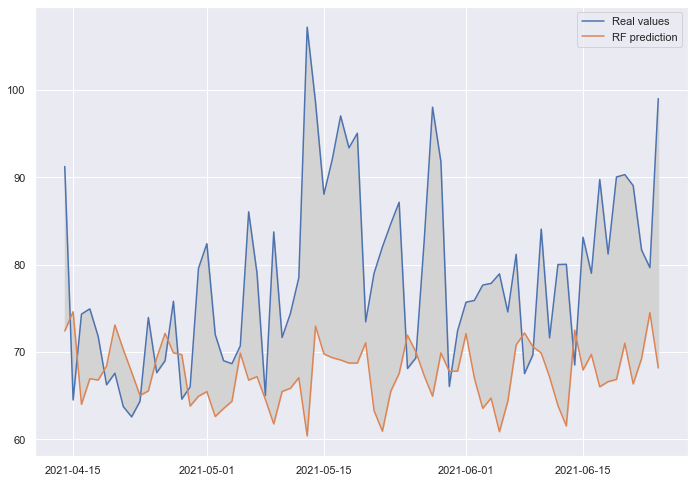

In [54]:
plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')

##### Plotting predicted and real values with some features

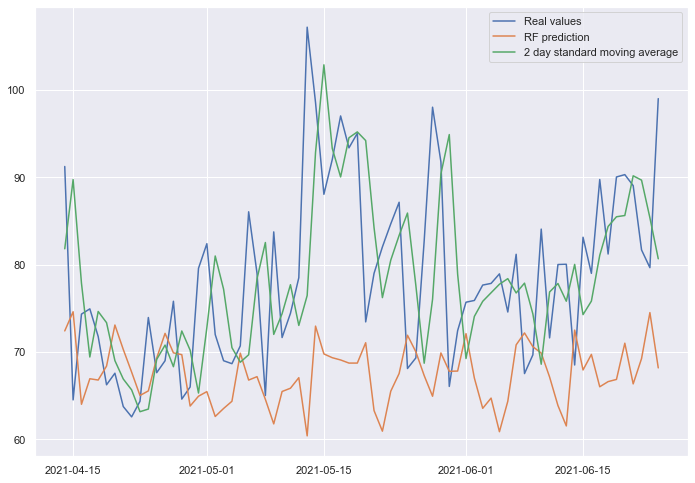

In [55]:
plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.plot(data_test.index, data_test['2_std_moving_average'], label='2 day standard moving average')
plt.legend()

<AxesSubplot:>

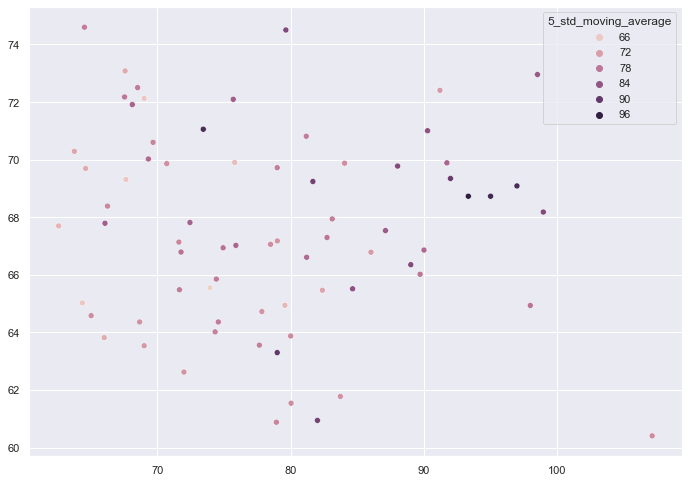

In [56]:
sns.scatterplot(x=y_test, y=y_hat, hue='5_std_moving_average', data=data_test)

#### Try RF, but first applying PCA and standarising

In [160]:
#We first scale the data
from sklearn.preprocessing import StandardScaler

X = data.drop(['value', 'diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y = data.value.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [161]:
#Reducing feature dimensionality with PCA
from sklearn.decomposition import PCA

#keep the first two principal components of the data 
pca = PCA(n_components=2)

#fit PCA model to data 
pca.fit(X_scaled)

#transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

In [162]:
#X_pca = X_scaled

print("Original shape: {}".format(str(X_scaled.shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (360, 21)
Reduced shape: (360, 2)


In [163]:
X_train = X_pca[:int(head)]
X_test = X_pca[len(X_pca)-int(tail):len(X_pca)]
y_train = y[:int(head)]
y_test = y[len(X_pca)-int(tail):len(X_pca)]

print("X train shape: {}".format(X_train.shape)) 
print("X test shape: {}".format(X_test.shape))
print("y train shape: {}".format(y_train.shape)) 
print("y test shape: {}".format(y_test.shape))

X train shape: (288, 2)
X test shape: (72, 2)
y train shape: (288,)
y test shape: (72,)


In [164]:
forest = RandomForestRegressor(n_estimators=10, min_samples_split= 2, 
                               min_samples_leaf=1, max_depth=9, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

##### Model Evaluation

In [165]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.896
Accuracy on test set: -0.388


In [166]:
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

R2 is -0.3877042609904362
The mean absolute error is 9.850129670907794
The root mean squared error is 142.95164625433296
The mean absolute percentage error is 12.053634177858443


##### Plotting predicted and real values

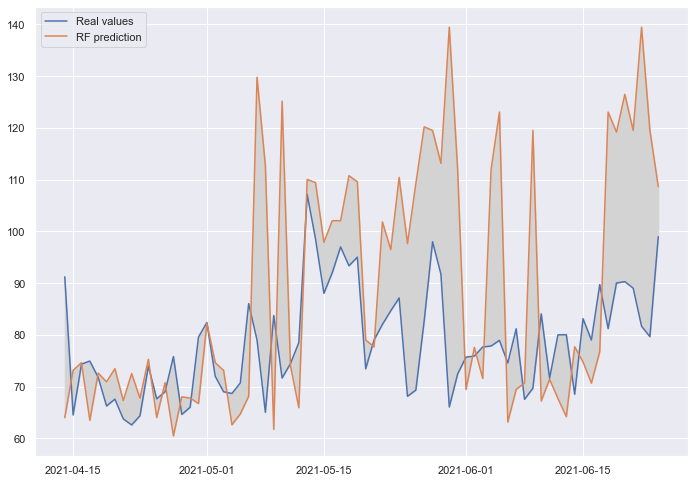

In [60]:
plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')

#### Summary of the model to see certain features

In [179]:
chosen_features= ['2_std_moving_average', '3_std_moving_average', '7_day_lag', '1_day_lag', 'ex_moving_average']

# Train data removing the string columns and the value and diff_value
X_train = data_train[chosen_features].values
y_train = data_train.value.values

# Test data removing the string columns and the value and diff_value
X_test = data_test[chosen_features].values
y_test = data_test.value.values

from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=1.0, l1_ratio=0.7)
forest = RandomForestRegressor(n_estimators=500, min_samples_split= 2, 
                               min_samples_leaf=3, max_depth=15, max_features='sqrt', random_state=0)
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

print("Accuracy on training set: {:.3f}".format(enet.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(enet.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

Accuracy on training set: 0.628
Accuracy on test set: 0.176
R2 is 0.17574376537094705
The mean absolute error is 7.074947042060332
The root mean squared error is 84.909147422754
The mean absolute percentage error is 8.785914034560362
